# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

The number of women/men in the dataset:
 male      577
female    314
Name: Sex, dtype: int64 



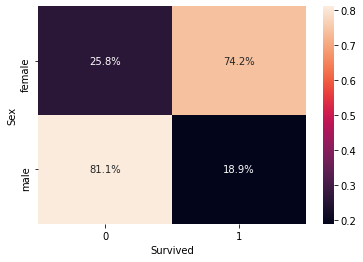

In [6]:
print("The number of women/men in the dataset:\n", data.Sex.value_counts(), "\n") # display the number of women/ men
conf_matrix = pd.crosstab(data.Sex, data.Survived, normalize='index') # calculate the survival rate by gender
sns.heatmap(conf_matrix, annot=True, fmt=".1%",); # display the output
# Note: pd.crosstab does a thing similar to a query below for all combinations of Survival (0,1) and Sex (male, female)
# print(data.query("Survived == 0 and Sex == 'female'")['Survived'].count()/data[data['Sex']=='female']['Survived'].count())

<hr>
If you take a look at the chart above, you'll see that the survival rate depends on a passenger's sex - most of the females boarded the Titanic managed to survive while the majority of males did not survive.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

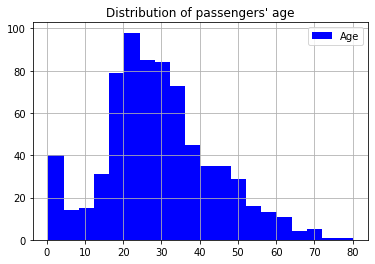

Survived passsengers: average age = 28.3, median age = 28
Deceased passsengers: average age = 30.6, median age = 28


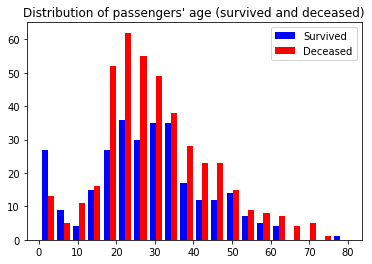

In [7]:
ages_survival = data[['Age', 'Survived']].dropna()# get Age and Survival columns, drop NULLs
ages_survival['Age'].hist(bins=20, legend=True, color='blue') # prepare the plot with the data separated into 10 ranges
plt.title('Distribution of passengers\' age') # add the title
plt.show() # draw the plot

ages_survived = ages_survival[ages_survival['Survived'] == 1]['Age'] # extract ages of those who survived
ages_deceased = ages_survival[ages_survival['Survived'] == 0]['Age'] # extract ages of those who did not
print(f"Survived passsengers: average age = {round(np.mean(ages_survived), 1)}, median age = {round(np.median(ages_survived))}")
print(f"Deceased passsengers: average age = {round(np.mean(ages_deceased), 1)}, median age = {round(np.median(ages_deceased))}")

plt.hist([ages_survived, ages_deceased], bins=20, label=['Survived', 'Deceased'], color=['blue', 'red'])
plt.title('Distribution of passengers\' age (survived and deceased)')
plt.legend() 
plt.show()

<hr>
The plot above demonstrates that the majority of babies survived while the majority of young and middle-aged adults didn't survive. The reason is yet to be known but most likely this group of adults purchased cheap tickets.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

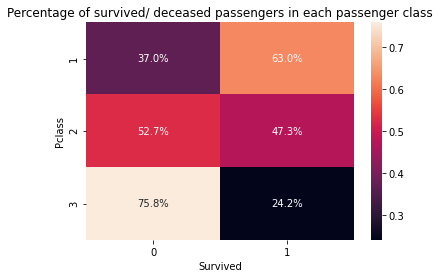

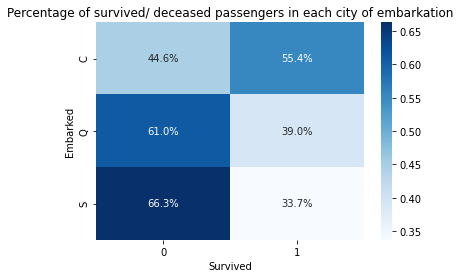

In [8]:
# calculate the survival rate by Passenger class
pclass_survived = pd.crosstab(data.Pclass, data.Survived, normalize='index')
sns.heatmap(pclass_survived, annot=True, fmt=".1%");
plt.title('Percentage of survived/ deceased passengers in each passenger class')
plt.show()

# calculate the survival rate by Embarked
embarked_survived = pd.crosstab(data.Embarked, data.Survived, normalize='index') 
sns.heatmap(embarked_survived, annot=True, fmt=".1%", cmap="Blues");
plt.title('Percentage of survived/ deceased passengers in each city of embarkation')
plt.show()

<hr>
We see that 1st passenger class is the only class where the number of survived passengers is higher than the number of those who didn't survive - thus, it's the safest class.
Also, it seems there is a relation between the city of embarkation and chances to survive as more than half of those who embarked the boat in "C" managed to survive.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [9]:
(100*(data.isna().sum()/data.shape[0])).to_frame('Percentage of N/A')

,Percentage of N/A
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.865320
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000
Cabin,77.104377


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

<hr>
I would choose a method judging by the percentage of missing values - given that Embarked column has a small number of NULLs, I would just drop rows with missing records. The disadvantage is that data is lost and cannot be used but the number of records is less than 1% - it seems to be the most suitable option.<br>
<br>
There are two remaining columns with missing values - Age and Cabin.<br>
<br>
Age column is a numeric column, so NULLs can be replaced with the average value. Thus, there is no data loss but the obious downside is the data in this column is no longer 'ground truth'. The other way is to predict values in this column. <br>Alternatively, as the number of missing values is < 30%, we can consider dropping rows with missing values.<br>
<br>
Speaking of 'Cabin' column which is a categorical feature, I think of replacing  NA with a new category called 'Unknown' as there is no obvious relation between other features and the class (I mean, N/As are not related to a single passenger class). Also, I could replace existing values with another 'Known' category. <br>
Thus, the data is not lost which is great but it's an 'artificial' category and may not correctly represent missing data.<br>
In addition, it's worth diving into the values stored in the column as it might turn out that these values are missing not because they were not recorded but because they don't exist - for example, these passengers don't have a specific cabin but they were in some commonplace (which doesn't seem to be the case) or they didn't have a cabin assigned before embarking.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [10]:
y = data['Survived']

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

encoder = OneHotEncoder()
train_data = data[['Pclass', 'Sex', 'Age', 'Survived', 'SibSp', 'Parch']].dropna().reset_index(drop=True)
Y = train_data['Survived']
train_data_to_be_encoded = train_data[['Pclass', 'Sex']]
train_data_encoded = encoder.fit_transform(train_data_to_be_encoded).toarray()
train_data_encoded = pd.DataFrame(train_data_encoded, columns=encoder.get_feature_names())

train_data['AgeNormalized'] = MinMaxScaler().fit_transform(train_data['Age'].to_numpy().reshape(-1, 1))
train_data = pd.merge(train_data_encoded, train_data[['AgeNormalized', 'SibSp', 'Parch']], left_index=True, right_index=True)

log_reg = LogisticRegression(solver='liblinear', penalty='l1', random_state=69)
log_reg.fit(train_data, Y)
print("Logistic Regression's average accuracy:", cross_val_score(log_reg, train_data, Y, scoring='accuracy', cv=5).mean())

k_neighbors_c = KNeighborsClassifier(n_neighbors=3)
k_neighbors_c.fit(train_data, Y)
print("KNN's average accuracy:", cross_val_score(k_neighbors_c, train_data, Y, scoring='accuracy', cv=5).mean())

Logistic Regression's average accuracy: 0.7829607012705605
KNN's average accuracy: 0.8123608785580616


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [18]:
# add a new feature to indicate whether a passenger was on board with their family
train_data['with_family'] = train_data.apply(lambda row: 1 if (row['SibSp'] + row['Parch']) >= 1 else 0, axis=1)
train_data.head()
train_date_fe = train_data[['with_family', 'AgeNormalized', 'x1_female', 'x1_male', 'x0_1','x0_2','x0_3']]
print("KNN's average accuracy:", cross_val_score(k_neighbors_c, train_date_fe, Y, scoring='accuracy', cv=5).mean())

KNN's average accuracy: 0.8123214813355659


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [19]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

test_data['AgeImputed'] = test_data['Age'].fillna(test_data['Age'].mean())
test_data['with_family'] = test_data.apply(lambda row: 1 if (row['SibSp'] + row['Parch']) >= 1 else 0, axis=1)

test_data_to_be_encoded = test_data[['Pclass', 'Sex']]
test_data_encoded = encoder.fit_transform(test_data_to_be_encoded).toarray()
test_data_encoded = pd.DataFrame(test_data_encoded, columns=encoder.get_feature_names())

test_data['AgeNormalized'] = MinMaxScaler().fit_transform(test_data['AgeImputed'].to_numpy().reshape(-1, 1))
test_X = pd.merge(test_data_encoded, test_data[['AgeNormalized', 'with_family']], left_index=True, right_index=True)

k_neighbors_c.fit(train_date_fe, Y)
test_survived_predicted = pd.Series(data=k_neighbors_c.predict(test_X), index=None, name='Survived')
submit = pd.merge(test_data['PassengerId'], test_survived_predicted, left_index=True, right_index=True)
submit.to_csv(path_or_buf=os.path.join(PATH, 'titanic', 'titanic_submission.csv'), sep=',', na_rep='', header=True, index=False)

## Part 2: Porto Seguro’s Safe Driver Prediction

In [ ]:
# PART 2 WILL BE DONE LATER - SEE announcements-2021q1 CHANNEL IN DISCORD

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [14]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

FileNotFoundError: [Errno 2] No such file or directory: './data/porto\\train.csv'

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code